In [19]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torch.functional as F
from torch.autograd import Function
import optuna
from modules import Trainer
from modules.competition_dataset import EEGDataset
from modules.utils import evaluate_model
import random
import numpy as np
from torch.utils.data import ConcatDataset, random_split, DataLoader
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[autoreload of modules.competition_dataset failed: Traceback (most recent call last):
  File "C:\Users\ahmad\AppData\Roaming\Python\Python312\site-packages\IPython\extensions\autoreload.py", line 280, in check
    elif self.deduper_reloader.maybe_reload_module(m):
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\ahmad\AppData\Roaming\Python\Python312\site-packages\IPython\extensions\deduperreload\deduperreload.py", line 533, in maybe_reload_module
    new_source_code = f.read()
                      ^^^^^^^^
  File "c:\Users\ahmad\AppData\Local\Programs\Python\Python312\Lib\encodings\cp1252.py", line 23, in decode
    return codecs.charmap_decode(input,self.errors,decoding_table)[0]
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
UnicodeDecodeError: 'charmap' codec can't decode byte 0x90 in position 9083: character maps to <undefined>
]


device(type='cuda')

In [20]:
# from google.colab import drive
# drive.mount('/content/drive')
# data_path = '/content/drive/MyDrive/ai_data/eeg_detection/data/mtcaic3'
# model_path = '/content/drive/MyDrive/ai_data/eeg_detection/checkpoints/ssvep/models/ssvep.pth'
# optuna_db_path = '/content/drive/MyDrive/ai_data/eeg_detection/checkpoints/ssvep/optuna/optuna_studies.db'
data_path = './data/mtcaic3'
model_path = './checkpoints/mi/models/the_honored_one.pth'
optuna_db_path = './checkpoints/mi/optuna/the_honored_one.db'
eeg_channels = [
    "C3", # 2296.15
    "PZ", # 1744.43
    "C4", # 1556.46
    "OZ", # 444.98
    "PO7", # 381.63
    "PO8", # 275.78
    "CZ", # 200.43
    "FZ", # 111.51
]

In [21]:
# Add this at the beginning of your notebook, after imports
def set_random_seeds(seed=42):
    """Set random seeds for reproducibility"""

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

# Call this function before creating datasets and models
set_random_seeds(42)

In [22]:
window_length = 128 * 2 # ensure divisble by 64 the kernel size
stride = window_length // 3
batch_size = 64

dataset_train = EEGDataset(
    data_path,
    window_length=window_length,
    stride=stride,
    domain="time",
    data_fraction=0.1,
    hardcoded_mean=True,
    task="mi",
    eeg_channels=eeg_channels,
)

dataset_val = EEGDataset(
    data_path=data_path,
    window_length=window_length,
    stride=stride,
    split='validation',
    read_labels=True,
    hardcoded_mean=True,
    data_fraction=1,
    task="mi",
    eeg_channels=eeg_channels,
)

train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(dataset_val,   batch_size=batch_size)

task: mi, split: train, domain: time, data_fraction: 0.1
Using 10.0% of data: 240/240 samples
skipped: 0/240
task: mi, split: validation, domain: time, data_fraction: 1
skipped: 0/50


In [23]:
dataset_train[0][0].shape

torch.Size([8, 40, 256])

In [ ]:
# ---------------- Gradient Reversal Layer ---------------- #
class GradientReversalFunction(Function):
    @staticmethod
    def forward(ctx, x, alpha):
        ctx.alpha = alpha
        return x.view_as(x)
    @staticmethod
    def backward(ctx, grad_output):
        return grad_output.neg() * ctx.alpha, None

class GradientReversal(nn.Module):
    def __init__(self, alpha=1.0):
        super().__init__()
        self.alpha = alpha
    def forward(self, x):
        return GradientReversalFunction.apply(x, self.alpha)


# ---------------- LSTM Head ---------------- #
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first=True)
        self.fc   = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0=None, c0=None):
        # x: B x seq_len x feat_dim
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device)
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim, device=x.device)
        out, _ = self.lstm(x, (h0, c0))
        return self.fc(out[:, -1, :])  # last time‐step


# ---------------- EEG Feature Extractor (3D) ---------------- #
class EEGFeatureExtractor3D(nn.Module):
    def __init__(self, n_electrodes, kernLength, F1, D, F2, dropout):
        super().__init__()
        # Input: B×C×F×T. After unsqueeze: B×1×C×F×T.
        # 1) Temporal+Spectral conv per electrode
        self.temporal_spec = nn.Sequential(
            nn.Conv3d(
                in_channels=1, out_channels=F1,
                kernel_size=(1,   5, kernLength),
                padding=(0,     2, kernLength//2),
                bias=False
            ),
            nn.BatchNorm3d(F1),
            nn.ELU(),
        )
        # 2) Depthwise spatial conv across electrodes
        self.spatial = nn.Sequential(
            nn.Conv3d(
                in_channels=F1, out_channels=F1*D,
                kernel_size=(n_electrodes, 1, 1),
                groups=F1, bias=False
            ),
            nn.BatchNorm3d(F1*D),
            nn.ELU(),
            nn.MaxPool3d((1,1,2)),  # half the time‐axis
            nn.Dropout(dropout),
        )
        # 3) Separable freq‐time conv
        self.separable = nn.Sequential(
            nn.Conv3d(
                in_channels=F1*D, out_channels=F1*D,
                kernel_size=(1, 7, 16),
                padding=(0, 3, 8),
                groups=F1*D, bias=False
            ),
            nn.Conv3d(
                in_channels=F1*D, out_channels=F2,
                kernel_size=1, bias=False
            ),
            nn.BatchNorm3d(F2),
            nn.ELU(),
            nn.MaxPool3d((1,1,2)),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        # x: B×C×F×T
        B, C, F, T = x.shape
        x = x.unsqueeze(1)         # → B×1×C×F×T
        x = self.temporal_spec(x)  # → B×F1×C×F×T_sub
        x = self.spatial(x)        # → B×(F1·D)×1×F×T_sub
        x = self.separable(x)      # → B×F2×1×F'×T_sub2

        # squeeze out the now‐unit “electrode” dim
        x = x.squeeze(2)           # B×F2×F'×T_sub2
        B, F2, Fp, Tp = x.shape

        # merge frequency into the feature axis:
        x = x.view(B, F2*Fp, Tp)   # B×feat_dim×T_sub2
        # finally, transpose for LSTM: B×T_sub2×feat_dim
        return x.permute(0, 2, 1)


# ---------------- DANN SSVEP Classifier ---------------- #
class DANN_SSVEPClassifier(nn.Module):
    def __init__(
        self,
        n_electrodes=16,
        out_dim=4,
        dropout=0.25,
        kernLength=256,
        F1=96,
        D=1,
        F2=96,
        hidden_dim=100,
        layer_dim=1,
        grl_alpha=0.0,
        domain_lstm_div=3,
        domain_classes=30,
    ):
        super().__init__()
        self.grl_alpha = grl_alpha
        self.feature_extractor = EEGFeatureExtractor3D(
            n_electrodes, kernLength, F1, D, F2, dropout
        )
        feat_dim = F2 * (40 // 1)  # update with actual F' if needed 

        # label predictor
        self.label_lstm = LSTMModel(feat_dim, hidden_dim, layer_dim, out_dim)

        # domain predictor (optional)
        self.grl = GradientReversal(alpha=grl_alpha)
        self.domain_lstm = LSTMModel(
            feat_dim,
            max(1, hidden_dim // domain_lstm_div),
            max(1, layer_dim  // domain_lstm_div),
            domain_classes
        )

    def forward(self, x):
        # x: B×C×F×T  (from your CWT)
        seq = self.feature_extractor(x)      # B×T_sub×feat_dim
        class_out = self.label_lstm(seq)     # B×out_dim
        # domain_out = self.domain_lstm(self.grl(seq))  
        # return class_out, domain_out
        return class_out, torch.zeros(class_out.shape[0], 30, device=device)

        
        

dummy_x = torch.randn(5, 8, 40, 256).to(device)
model = DANN_SSVEPClassifier(
    dropout=0.26211635308091535,
    n_electrodes=8,
    out_dim=2,
    domain_classes=30,
    kernLength=8,
    F1=8,
    D=2,
    F2=16,
    hidden_dim=256,
    layer_dim=1,
    grl_alpha=0,
    domain_lstm_div=3,
).to(device)

print('worked dude')
model(dummy_x)

worked dude


(tensor([[0.1977, 0.2633],
         [0.2720, 0.2633],
         [0.0561, 0.2227],
         [0.1766, 0.2022],
         [0.0668, 0.1376]], device='cuda:0', grad_fn=<AddmmBackward0>),
 tensor([[-0.1475,  0.2599],
         [-0.1727,  0.1486],
         [ 0.0765,  0.1098],
         [ 0.0762,  0.0259],
         [-0.0045, -0.0461]], device='cuda:0', grad_fn=<AddmmBackward0>))

In [25]:
avg_losses_label = []
avg_losses_domain = []
val_label_accuracies = []
val_domain_accuracies = []
train_label_accuracies = []
train_domain_accuracies = []

In [30]:
from torch.utils.data import Subset, DataLoader

# ——— pick your held-out subject(s) ———
# e.g. single subject index 29 (0-based):
target_subject = 29

# your EEGDataset stores the subject label in dataset.subjects (shape [N])
# build two index lists:
is_target = (dataset_train.subjects == target_subject)
target_indices = torch.nonzero(is_target, as_tuple=True)[0].tolist()
source_indices = torch.nonzero(~is_target, as_tuple=True)[0].tolist()

train_loader = DataLoader(
    Subset(dataset_train, source_indices),
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
)
target_loader = DataLoader(
    Subset(dataset_train, target_indices),
    batch_size=batch_size,
    shuffle=True,
    num_workers=4,
)

In [31]:
try:
    model.load_state_dict(torch.load(model_path, weights_only=True))
except Exception:
    print("skipping model loading...")


opt = torch.optim.Adam(model.parameters(), lr=0.0003746351873334935)
criterion = nn.CrossEntropyLoss()
epochs = 200
domain_loss_weight = 1

for epoch in range(epochs):
    avg_loss_label = 0
    avg_loss_domain = 0
    correct_label = 0
    correct_domain = 0
    total = 0
    model.train()
    model.to(device)
    

    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device).to(torch.int64) # shape: [Bx2], 0: label, 1: domain
        y_labels = y[:, 0]
        y_subj = y[:, 1]

        y_pred_labels, y_pred_domain = model(x)
        y_pred_labels = y_pred_labels
        y_pred_domain = y_pred_domain

        loss_label = criterion(y_pred_labels, y_labels)
        # loss_domain = criterion(y_pred_domain, y_subj)
        # loss = loss_label + domain_loss_weight * loss_domain
        loss = loss_label
        
        opt.zero_grad()
        loss.backward()
        opt.step()

        avg_loss_label += loss.item()
        # avg_loss_domain += loss_domain.item()

        # Accuracy calculation
        _, pred_labels = torch.max(y_pred_labels, 1)
        _, pred_domains = torch.max(y_pred_domain, 1)
        correct_label += (pred_labels == y_labels).sum().item()
        correct_domain += (pred_domains == y_subj).sum().item()
        total += y_labels.size(0)

    avg_loss_label /= len(train_loader)
    avg_loss_domain /= len(train_loader)
    avg_losses_label.append(avg_loss_label)
    avg_losses_domain.append(avg_loss_domain)
    train_label_acc = 100.0 * correct_label / total
    train_domain_acc = 100.0 * correct_domain / total
    train_label_accuracies.append(train_label_acc)
    train_domain_accuracies.append(train_domain_acc)

    if (epoch + 1) % 5 == 0:
        label_evaluation, domain_evaluation = evaluate_model(model, val_loader, device)
        val_label_accuracies.append(label_evaluation)
        val_domain_accuracies.append(domain_evaluation)
        model.cpu()
        torch.save(model.state_dict(), model_path)
        print(f"{epoch}: avg_loss_label: {avg_loss_label:.3F}, avg_loss_domain: {avg_loss_domain:.3F}, train_label_acc: {train_label_acc:.2f}%, train_domain_acc: {train_domain_acc:.2f}%, label_evaluation: {(label_evaluation*100):.2f}, domain_evaluation: {(domain_evaluation*100):.2f}%, lr: {opt.param_groups[0]['lr']}")

skipping model loading...


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "c:\Users\ahmad\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\_utils\worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
           ^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ahmad\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\_utils\fetch.py", line 50, in fetch
    data = self.dataset.__getitems__(possibly_batched_index)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ahmad\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataset.py", line 416, in __getitems__
    return [self.dataset[self.indices[idx]] for idx in indices]
            ~~~~~~~~~~~~^^^^^^^^^^^^^^^^^^^
  File "c:\Users\ahmad\OneDrive\سطح المكتب\zeyadcode\aic-eeg-classification\modules\competition_dataset.py", line 301, in __getitem__
    j  = np.random.randint(len(self))
                           ^^^^^^^^^
TypeError: object of type 'EEGDataset' has no len()


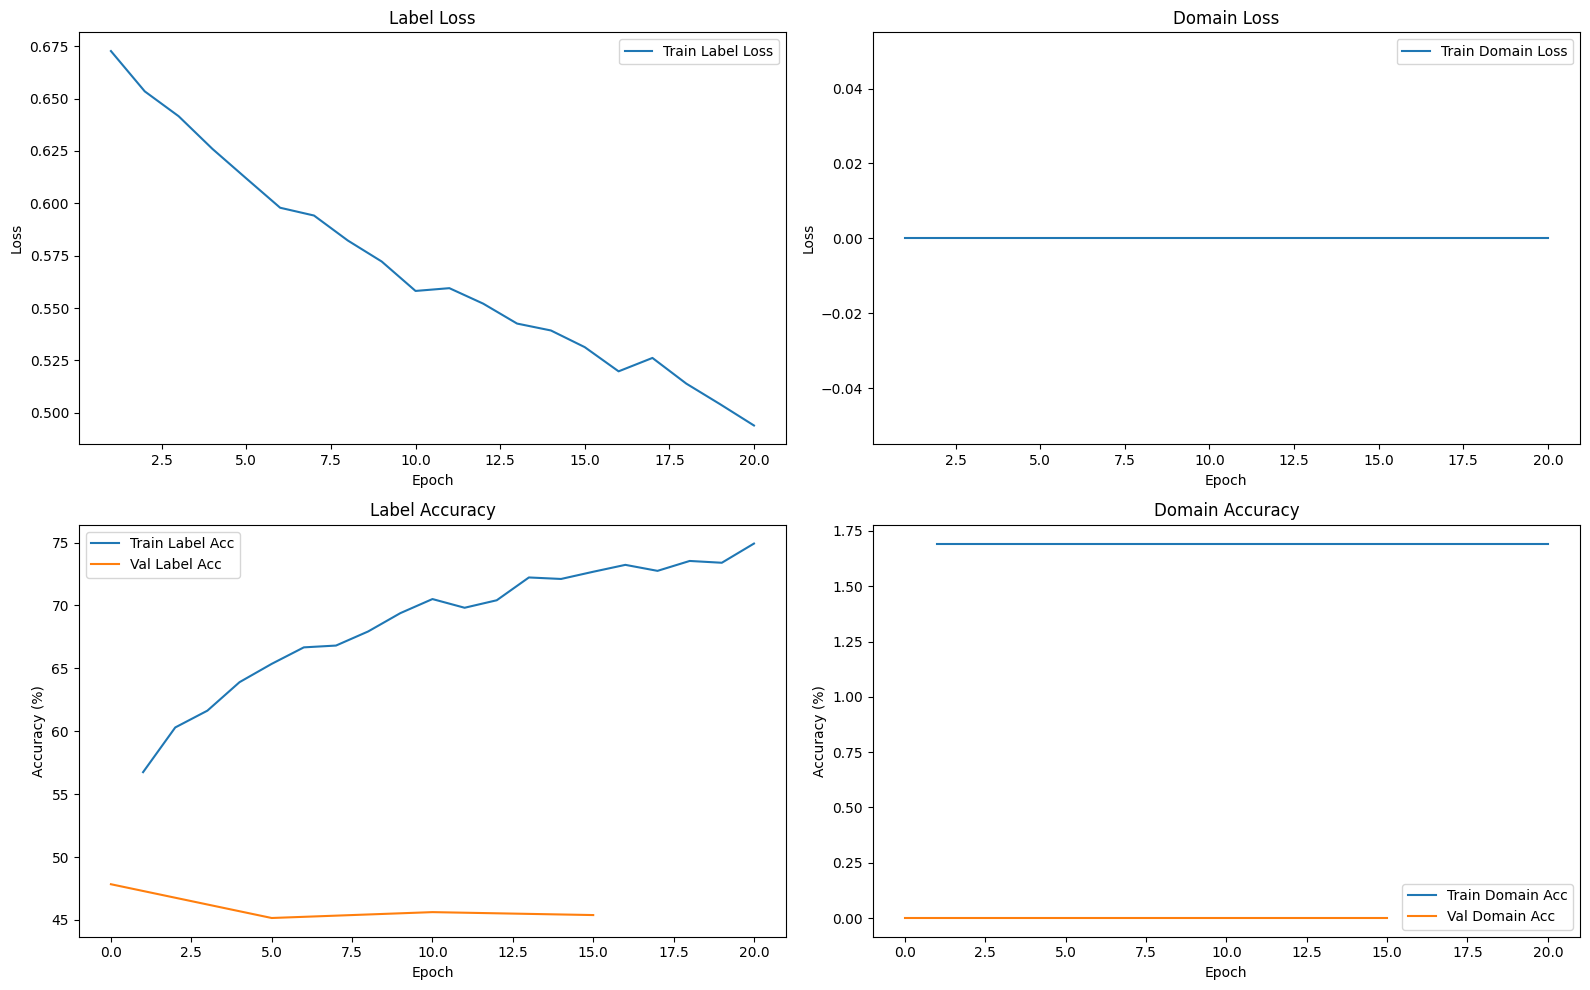

In [17]:
epochs = range(1, len(avg_losses_label) + 1)
val_epochs = range(0, len(val_label_accuracies) * 5, 5)  # if you log every 5 epochs

plt.figure(figsize=(16, 10))

# 1. Label Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, avg_losses_label, label='Train Label Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Label Loss')
plt.legend()

# 2. Domain Loss
plt.subplot(2, 2, 2)
plt.plot(epochs, avg_losses_domain, label='Train Domain Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Domain Loss')
plt.legend()

# 3. Label Accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, train_label_accuracies, label='Train Label Acc')
plt.plot(val_epochs, [v*100 for v in val_label_accuracies], label='Val Label Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Label Accuracy')
plt.legend()

# 4. Domain Accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, train_domain_accuracies, label='Train Domain Acc')
plt.plot(val_epochs, [v*100 for v in val_domain_accuracies], label='Val Domain Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Domain Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
class CustomTrainer(Trainer):
    # This method is called by _objective during an Optuna trial
    def prepare_trial_run(self):
        assert isinstance(self.trial, optuna.Trial), "Trial not set!"

        # 1. Define Hyperparameters for this trial
        #    a. Data/Loader parameters
        window_length = self.trial.suggest_categorical("window_length", [128, 256, 640]) # e.g. 64*2, 64*4, 64*10
        batch_size = self.trial.suggest_categorical("batch_size", [32, 64])

        #    b. Model architecture parameters
        kernLength = self.trial.suggest_categorical("kernLength", [64, 128, 256])
        F1 = self.trial.suggest_categorical("F1", [8, 16, 32])
        D = self.trial.suggest_categorical("D", [1, 2, 3])
        F2 = self.trial.suggest_categorical("F2", [16, 32, 64]) # F2 must be F1 * D
        hidden_dim = self.trial.suggest_categorical("hidden_dim", [64, 128, 256])
        layer_dim = self.trial.suggest_categorical("layer_dim", [1, 2, 3])
        dropout = self.trial.suggest_float("dropout", 0.1, 0.6)
        grl_alpha = self.trial.suggest_float("grl_alpha", 0.0, 1.0)
        domain_lstm_div = self.trial.suggest_int("domain_list_div", 1, 5)
        
        #    c. Optimizer parameters
        lr = self.trial.suggest_float("lr", 1e-4, 1e-2, log=True)

        # 2. Prepare the data using these parameters
        super()._prepare_data(is_trial=True, batch_size=batch_size, window_length=window_length)
        

        # 3. Build the model and optimizer
        self.model = DANN_SSVEPClassifier(
            n_electrodes=8, # Use value from data
            dropout=dropout,
            kernLength=kernLength,
            F1=F1,
            D=D,
            F2=F1 * D, # F2 is dependent on F1 and D
            hidden_dim=hidden_dim,
            layer_dim=layer_dim,
            grl_alpha=grl_alpha,
        ).to(self.device)
        
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=lr)

    # This method is called by train() for the final run
    def prepare_final_run(self):
        # 1. Get the best hyperparameters from the completed study
        study = self._get_study()
        best_params = study.best_params
        
        # 2. Prepare data using the best params
        super()._prepare_data(is_trial=False) # is_trial=False handles getting params from study
        
        # 3. Build the final model and optimizer
        self.model = DANN_SSVEPClassifier(
            n_electrodes=8,
            out_dim=2,
            domain_classes=30,
            dropout=best_params["dropout"],
            kernLength=best_params["kernLength"],
            F1=best_params["F1"],
            D=best_params["D"],
            F2=best_params["F1"] * best_params["D"],
            hidden_dim=best_params["hidden_dim"],
            layer_dim=best_params["layer_dim"],
            grl_alpha=best_params["grl_alpha"],
            domain_lstm_div=best_params["domain_lstm_div"],
        ).to(self.device)
        
        # Optional: Load pre-existing weights if you are resuming
        try:
            self.model.load_state_dict(torch.load(self.model_path))
            print(f"Loaded existing model weights from {self.model_path}")
        except Exception:
            print(f"No existing model weights found at {self.model_path}. Training from scratch.")
        
        lr = best_params["lr"]
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)
        self.scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            self.optimizer,
            mode='max',        # “min” if you want to reduce lr when the quantity monitored has stopped decreasing
            factor=0.5,        # new_lr = lr * factor
            patience=20,        # number of epochs with no improvement after which lr will be reduced
            threshold=1e-4,    # threshold for measuring the new optimum, to only focus on significant changes
            threshold_mode='rel', # `'rel'` means compare change relative to best value. Could use `'abs'`.
            cooldown=0,        # epochs to wait before resuming normal operation after lr has been reduced
            min_lr=1e-6,       # lower bound on the lr
        )

trainer = CustomTrainer(
        data_path=data_path,
        optuna_db_path=optuna_db_path,
        model_path=model_path,
        train_epochs=500, # Final training epochs
        tune_epochs=50,   # Epochs per trial
        optuna_n_trials=50,
        task="mi",
        eeg_channels=eeg_channels,
        data_fraction=0.4
    )

In [ ]:
delete_existing = False
trainer.optimize(delete_existing)

In [ ]:
trainer.train()

In [ ]:
trainer._prepare_training(False)
trainer.model.eval()
f"test accuracy: {evaluate_model(trainer.model, trainer.eval_loader, device)}"